<h1 style="text-align: center">Kaggle Titanic Dataset</h1>
<h3 style="text-align: center">Predicting passenger survival</h3>


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
from IPython.display import clear_output

ALPHA = 0.0002
ESPILON = 0.00001
TRAIN_DATA_FILE = "train.csv"
TEST_DATA_FILE = "test.csv"
DATA_OUTPUT_NAME = "answers.csv"

UNKNOWN_AGE_INSERT = 30 # This is the assumption for the passenger if the age is unknown.

## Fetching and Organizing Data

#### Raw Passenger Data
Passenger Data is returned as a list of strings, in the order of the following:
*Passenger Id, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked*

#### Parsed Passenger Data
Passenger Data needs to be parsed and converted into numbers for the machine learning algorithms to take over. The following will be the parsing scheme. This will also be the order as well

1. **Passenger Id**: This will stay the same, nor will be converted into an int.
2. **Survived**: 0 for died, 1 for survived
3. **Pclass**: 1 for upper class, 2 for middle class, 3 for lower class
4. **Sex**: 0 for Male, 1 for Female
5. **Age**: Float from the string, if it is an empty string then going to default to age of 30 (arbitrary).
6. **SibSp**: Sibling/Spouse on board, staying the same.
7. **Parch**: # of Parent/Children on board, staying the same.
8. **Fare**: Convert to a float

In [38]:
def FetchPassengerData(fileName: str) -> list:
    """Gets the information and then returns a list of the passengers in the format shown below (as strings)

    Args:
        fileName (str): The csv file to open

    Returns:
        list: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked 
    """
    result = []
    with open(fileName, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            result.append(row)
    return result

def ParseSurvived(survived: str) -> int:
    try:
        return int(float(survived))
    except Exception as ex:
        print(str(ex))
        return 0


def ParseAge(age: str) -> int:
    try:
        return float(age)
    except ValueError:
        return UNKNOWN_AGE_INSERT 

def ParseFare(fare, pclass):
    try:
        if fare == '':
            if pclass == 1:
                return 70
            elif pclass == 2:
                return 25
            else:
                return 7.25
        else:
            return float(fare)
    except ValueError:
        print("Parseing fare went wrong.")
        return 7.25
    except Exception as ex:
        print(f"ParseFare error: {ex}")
        return 7.25

def ParsePassengerData(passenger: list) -> list:
    """Takes passenger data and converts all the types to be usable for the machine learning. See the paragraph above for the information.
     

    Args:
        passenger (list): PassengerId, Survived (optional), Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

    Returns:
        list: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare
    """
    try:
        # Passenger surviving wasn't added. Add a '0' for survivied (mirroring test data)
        if len(passenger) < 12:
            passenger.insert(1, '0')
        
        if len(passenger) < 12:
            print("List is less than 12 elements still.")
            print(f"Passenger: {passenger}")
            raise Exception(ValueError)
        
        PassengerId = float(passenger[0])
        Survived = float(ParseSurvived(passenger[1]))
        Pclass = float(passenger[2])
        #  Name is irrelevant (passenger[3])
        Sex = float(passenger[4] == 'female')
        Age = ParseAge(passenger[5])
        SibSp = float(passenger[6])
        Parch = float(passenger[7])
        # Ticket is irrelevant (passenger[8])
        Fare = ParseFare(passenger[9], Pclass)
        # Cabin will be relevant -- going to eventually make up a scheme and numbering system based general cabin location.
        # I doubt embarked will matter, might be worth adding later.
    except ValueError:
        print("Value Error")
        print(f"Passenger: {passenger}")
        raise Exception(ValueError)

    return [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare]


### Training Function (and running)

In [39]:
def MakePredictions(TestData, W_HAT, B):
    Correct = 0
    Wrong = 0

    for passenger in TestData:
        Prediction = np.dot(passenger[2:], W_HAT) + B
        if Prediction > 0.5:
            Guess = True
        else:
            Guess = False
        
        if bool(passenger[1]) == Guess:
            Correct += 1
        else:
            Wrong += 1
    
    return Correct / (Correct + Wrong)

def TrainData():
    TrainRawData = FetchPassengerData(TRAIN_DATA_FILE) # Fetchin the raw data from the CSV file
    AllTrainData = [np.array(ParsePassengerData(passenger)) for passenger in TrainRawData[1:]] # The data parsed to use to train
    NumAttributes = len(AllTrainData[0]) # Number of Characteristics
    NumTotalPassengers = len(AllTrainData) # Number of Passengers

    TrainData = AllTrainData[:(int(NumTotalPassengers * 0.9))]
    TestData = AllTrainData[NumTotalPassengers - (int(NumTotalPassengers * 0.1)):]
    NumPassengers = len(TrainData)

    W_HAT = np.array([int(0) for i in range(6)]) # W_HAT all 0's for characteristics of Passenger Data
    B = 0 # Correction number
    HIST_COST = []
    HIST_J = [] # History of the derivative (used to check alpha)
    HIST_TEST = []
    ITERATION = 0 # Current Iteration Count
    PreviousCost = 1000 # Arbitrarily set, will change
    CostDifference = 1000 # Arbitrarily set

    print("Starting...")
    # Loop either for 100000 iterations or until the rate of change is less than or equal to ESPILON
    while ITERATION < 50000 and CostDifference > ESPILON:
        ITERATION += 1

        # Calculate the current cost
        cost = 0
        temp_cost = 0
        for passenger in TrainData:
            temp_cost = (np.dot(passenger[2:], W_HAT) + B) - passenger[1]
            cost += temp_cost * temp_cost

        cost = cost / (2 * NumPassengers)

        W_HAT_TEMP = []
        temp_dj_dws = []

        for index in range(NumAttributes - 2):
            sum = 0
            for passenger in TrainData:
                sum += ( (np.dot(passenger[2:], W_HAT) + B) - passenger[1] ) * passenger[2 + index]
            dj_dw = sum / NumPassengers
            W_HAT_TEMP.append(W_HAT[index] - (ALPHA * dj_dw))
            temp_dj_dws.append(dj_dw)

        temp_B = B
        for passenger in TrainData:
            sum += (np.dot(passenger[2:], W_HAT) + B) - passenger[1]
        dj_db = sum / NumPassengers
        temp_B = B - (ALPHA * dj_db)
        
        #Update W_Hat and B
        W_HAT = np.array(W_HAT_TEMP)
        B = temp_B

        # Test the data
        Accuracy = MakePredictions(TestData, W_HAT, B)
        AccuracyView = "{:.1f}%".format(Accuracy * 100)

        if ITERATION % 1000 == 0:
            clear_output(wait=True)
            print(f"\nIteration {ITERATION}: \n\tCost ({cost}) \n\tW_Hat: {W_HAT}\n\tB: {B} \n\tAccuracy: {AccuracyView}")

        #Save History every 1000 trials
        if ITERATION % 100 == 0:
            HIST_COST.append(cost)
            HIST_J.append(temp_dj_dws.append(dj_db))
            HIST_TEST.append(Accuracy)
            CostDifference = PreviousCost - cost
            PreviousCost = cost

    #Post training loop
    output = f"Iteration: {ITERATION}"
    print(f"\nNumber of Iterations: {ITERATION}")
    print(f"W_Hat: {W_HAT}")
    print(f"B = {B}")
    print(f"Accuracy: {AccuracyView}")
    return W_HAT, B, HIST_COST, HIST_J, HIST_TEST

W_HAT, B, HIST_COST, HIST_J, HIST_TEST = TrainData()


        


Iteration 49000: 
	Cost (0.07673117908623775) 
	W_Hat: [-3.22888458e-02  5.02942106e-01 -2.24767429e-05 -3.55160536e-02
 -1.36080227e-02  1.63616895e-03]
	B: 0.23440821751858307 
	Accuracy: 77.5%

Number of Iterations: 49200
W_Hat: [-3.24985297e-02  5.03478316e-01 -3.01141963e-05 -3.55147484e-02
 -1.37144004e-02  1.63355985e-03]
B = 0.2350837664563657
Accuracy: 77.5%


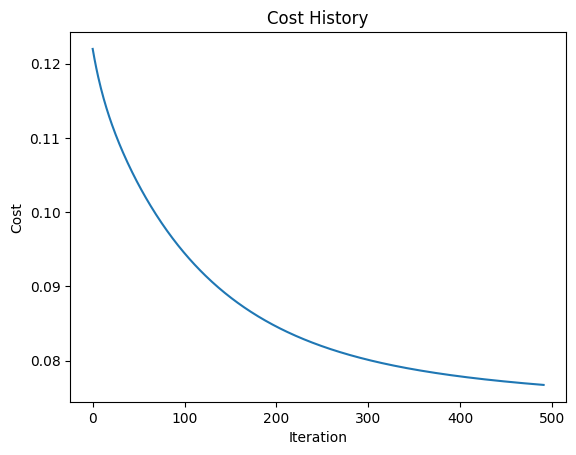

In [40]:
plt.plot(HIST_COST)
plt.title("Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

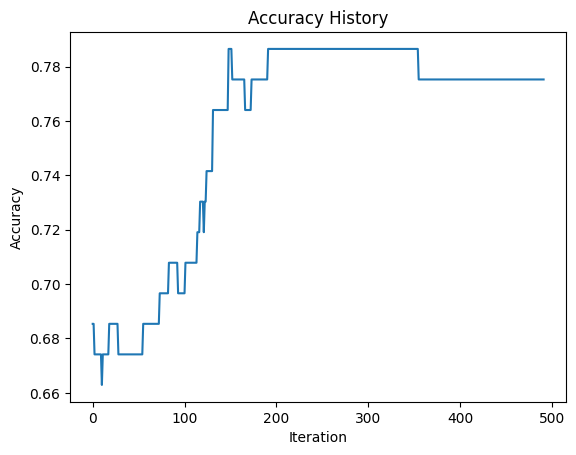

In [41]:
plt.plot(HIST_TEST)
plt.title("Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [42]:
# Testing the formula
def MakePredictions():
    TestRawData = FetchPassengerData(TEST_DATA_FILE) # Fetchin the raw data from the CSV file
    TestData = [np.array(ParsePassengerData(passenger)) for passenger in TestRawData[1:]] # The data parsed to use to train
    Correct = 0
    Wrong = 0
    PredictionList = []

    for passenger in TestData:
        Prediction = np.dot(passenger[2:], W_HAT) + B
        if Prediction > 0.5:
            Guess = True
        else:
            Guess = False
        
        PredictionList.append((passenger[0], Prediction, Guess))
    
    return PredictionList

Predictions = MakePredictions()

In [43]:
def WriteAnswersCSVFile(fname, PredictionList):

    with open(fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['PassengerId', 'Survived'])

        for pred in PredictionList:
            result = [str(int(pred[0]))]
            if pred[2]:
                result.append('1')
            else:
                result.append('0')
            
            writer.writerow(result)

WriteAnswersCSVFile('submission.csv', Predictions)